### 导入模拟数据

使用模拟数据，测试模型

In [1]:
import os
import numpy as np
import tensorflow as tf

os.chdir("/home/num_24/桌面/mywork/github/TFDeepSurv")
os.getcwd()

np.random.seed(10)

from dataset import SimulatedData
import LDeepSurv as LDS

data_config = SimulatedData(2000, num_var = 2, num_features = 10)
data = data_config.generate_data(2000)

### 模型训练

设置网络参数：
- 隐藏层：[6, 3]
- 学习率：learning_rate=0.001
- 激活函数：activation='tanh',
- 正则化参数：L1_reg=0.01, L2_reg=0.01,
- 优化算法：optimizer='sgd'

训练参数：
- 迭代次数：num_epoch=3000

features:  10
INFO:tensorflow:Scale of 0 disables regularizer.
-------------------------------------------------
training steps 1:
loss = 10413.9.

CI = 0.507801.

-------------------------------------------------
training steps 501:
loss = 9492.73.

CI = 0.787072.

-------------------------------------------------
training steps 1001:
loss = 9249.97.

CI = 0.818925.

-------------------------------------------------
training steps 1501:
loss = 9199.57.

CI = 0.823609.

-------------------------------------------------
training steps 2001:
loss = 9195.93.

CI = 0.823784.



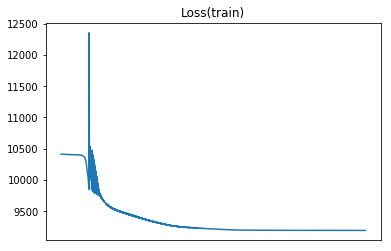

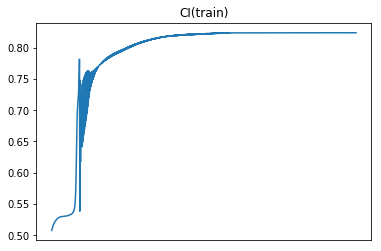

In [2]:
n_features = data['x'].shape[1]
print("features: ", n_features)
model = LDS.LDeepSurv(n_features, [7, 3], 1, 
                      learning_rate=0.001,
                      learning_rate_decay=0.999,
                      activation='tanh', 
                      L1_reg=0.0, 
                      L2_reg=0.0, 
                      optimizer='sgd')

model.train(data['x'], {'e': data['e'], 't': data['t']}, 
            num_epoch=2500, iteration=500,
            plot_train_loss=True, plot_train_CI=True)

### 网络测试

使用一致性指数评估（CI）:
- 训练集上的评估
- 独立测试集上的评估

In [3]:
X = data['x']
label = {'e': data['e'], 't': data['t']}
print("CI on train set: %g" % model.eval(X, label))

# 生成测试集数据
test_data = data_config.generate_data(800)
sort_idx = np.argsort(test_data['t'])[::-1]
test_data['x'] = test_data['x'] [sort_idx]
test_data['e'] = test_data['e'] [sort_idx]
test_data['t'] = test_data['t'] [sort_idx]
test_X = test_data['x']
test_label = {'e': test_data['e'], 't': test_data['t']}
print("CI on train set: %g" % model.eval(test_X, test_label))

CI on train set: 0.838422
CI on train set: 0.834073


In [4]:
model.evaluate_var_byWeights()

0th feature score : 0.18835.
1th feature score : 1.
2th feature score : 0.0142364.
3th feature score : 0.0272221.
4th feature score : 0.0182181.
5th feature score : -0.056904.
6th feature score : -0.0357386.
7th feature score : 0.0160053.
8th feature score : -0.00491783.
9th feature score : 0.0803691.


array([ 0.18834986,  1.        ,  0.0142364 ,  0.02722208,  0.01821805,
       -0.05690402, -0.03573862,  0.01600533, -0.00491783,  0.08036913], dtype=float32)

### 不同个体的生存函数预测

比例风险模型：$$h(t|x) = h_0(t)\cdot e^{\beta \cdot x}$$
对应的生存函数关系：$$S(t|x) = S_0(t)^{e^{\beta \cdot x}}$$

采用不同的估计方法得到**基准生存函数**：
$$S_0(t) = \prod_{i: t_i < t} C_i$$
- WWE方法：允许ties出现，论文中提出的新的估计方法；
- KP方法：未考虑ties的出现；
- bls方法：考虑了ties的出现， 但是可能会出现负值。

In [5]:
# 得到基准生存函数（基于整个训练数据人群）
# wwe方法：
T0_wwe, S0_wwe = model.basesurv(algo='wwe')
# KP方法：
T0_kp, S0_kp = model.basesurv(algo='kp')
# wwe方法：
T0_bsl, S0_bsl = model.basesurv(algo='bsl')

print("wwe : ", S0_wwe)
print("kp : ", S0_kp)
print("bsl : ", S0_bsl)

wwe :  [ 1.          0.99987226  0.99974409 ...,  0.0445003   0.0445003   0.0445003 ]
kp :  [ 1.          0.99987235  0.99974439 ...,  0.04439921  0.04439921
  0.04439921]
bsl :  [ 1.          0.99987243  0.9997447  ...,  0.04429729  0.04429729
  0.04429729]


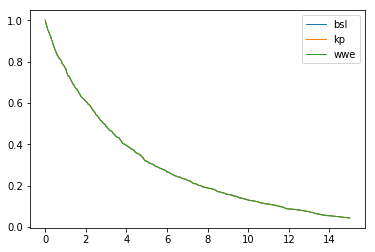

In [6]:
# 在同一个图中（使用同一训练数据，三种对基准生存函数不同的估计方法）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
data = pd.DataFrame({'wwe': S0_wwe, 'kp': S0_kp, 'bsl': S0_bsl}, index = T0_wwe)
data.plot(lw=1)

预测特定个体的生存曲线：

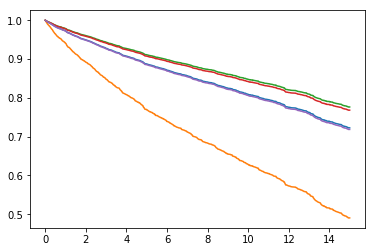

(array([  0.00000000e+00,   3.99762415e-04,   1.22133363e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99998667,  0.9999733 , ...,  0.72277126,
          0.72277126,  0.72277126],
        [ 1.        ,  0.99997077,  0.99994144, ...,  0.49058407,
          0.49058407,  0.49058407],
        [ 1.        ,  0.99998961,  0.99997919, ...,  0.77645583,
          0.77645583,  0.77645583],
        [ 1.        ,  0.99998918,  0.99997832, ...,  0.76828179,
          0.76828179,  0.76828179],
        [ 1.        ,  0.99998644,  0.99997283, ...,  0.71863811,
          0.71863811,  0.71863811]]))

In [7]:
model.survivalRate(X[0:5], algo="wwe")

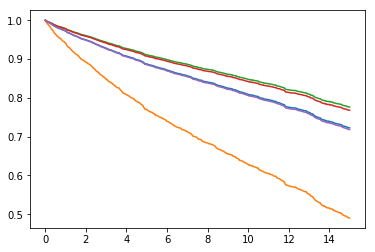

(array([  0.00000000e+00,   3.99762415e-04,   1.22133363e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99998668,  0.99997333, ...,  0.72259981,
          0.72259981,  0.72259981],
        [ 1.        ,  0.99997079,  0.99994151, ...,  0.49032884,
          0.49032884,  0.49032884],
        [ 1.        ,  0.99998962,  0.99997922, ...,  0.77631229,
          0.77631229,  0.77631229],
        [ 1.        ,  0.99998919,  0.99997835, ...,  0.76813381,
          0.76813381,  0.76813381],
        [ 1.        ,  0.99998645,  0.99997286, ...,  0.71846463,
          0.71846463,  0.71846463]]))

In [8]:
model.survivalRate(X[0:5], algo="kp")

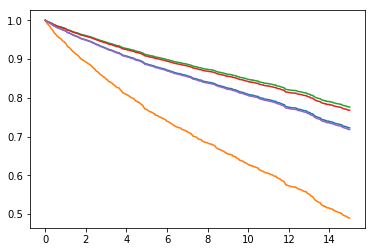

(array([  0.00000000e+00,   3.99762415e-04,   1.22133363e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99998669,  0.99997336, ...,  0.72242659,
          0.72242659,  0.72242659],
        [ 1.        ,  0.99997081,  0.99994158, ...,  0.49007105,
          0.49007105,  0.49007105],
        [ 1.        ,  0.99998963,  0.99997924, ...,  0.77616726,
          0.77616726,  0.77616726],
        [ 1.        ,  0.99998919,  0.99997837, ...,  0.76798431,
          0.76798431,  0.76798431],
        [ 1.        ,  0.99998646,  0.99997289, ...,  0.71828935,
          0.71828935,  0.71828935]]))

In [9]:
model.survivalRate(X[0:5], algo="bsl")

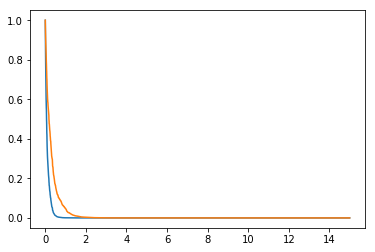

(array([  0.00000000e+00,   3.99762415e-04,   1.22133363e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.96439135e-01,   9.92878270e-01, ...,
           1.80228355e-38,   1.80228355e-38,   1.80228355e-38],
        [  1.00000000e+00,   9.98536782e-01,   9.97070478e-01, ...,
           3.21062121e-16,   3.21062121e-16,   3.21062121e-16]]))

In [10]:
model.survivalRate(X[-2:], algo='wwe')

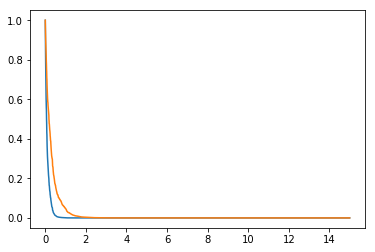

(array([  0.00000000e+00,   3.99762415e-04,   1.22133363e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.96441508e-01,   9.92886755e-01, ...,
           1.69138330e-38,   1.69138330e-38,   1.69138330e-38],
        [  1.00000000e+00,   9.98537758e-01,   9.97073976e-01, ...,
           3.12800512e-16,   3.12800512e-16,   3.12800512e-16]]))

In [11]:
model.survivalRate(X[-2:], algo='kp')

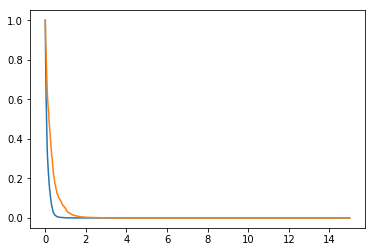

(array([  0.00000000e+00,   3.99762415e-04,   1.22133363e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.96443879e-01,   9.92895224e-01, ...,
           1.58624326e-38,   1.58624326e-38,   1.58624326e-38],
        [  1.00000000e+00,   9.98538733e-01,   9.97077467e-01, ...,
           3.04667635e-16,   3.04667635e-16,   3.04667635e-16]]))

In [12]:
model.survivalRate(X[-2:], algo='bsl')

采用原来代码中的方法进行估计：

原来代码中估计方法为：
- 先估计基准风险函数$h_0(t_i)=1-c_i$，$c_i$采用K&P方法计算得到，同时累积求和，得到$H_0(t_i)$ (这个就是累积基准风险函数么？)。
- 根据比例风险模型公式，由网络预测得到比例风险后，得到$h(t|x) = h_0(t)\cdot e^{\beta \cdot x}$，累积风险函数同样适用于这个公式，即：$H(t|x) = H_0(t)\cdot e^{\beta \cdot x}$；
- 再由公式$H_0(t) = -In S_0(t), S_0(t) = e^{-H_0(t)}$，从而得到生存函数。

公式$H_0(t) = -In S_0(t), S_0(t) = e^{-H_0(t)}$中，$H_0(t)$指的是累积风险函数，而累积风险函数与风险函数的关系为：
$$H_0(t) = \int_{0}^{t} h_0(x) dx$$

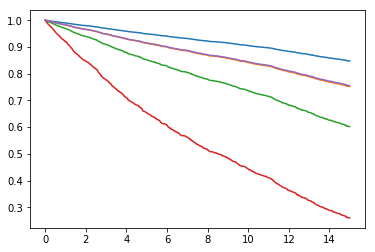

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99999399,  0.99998798, ...,  0.84792306,
          0.84792306,  0.84792306],
        [ 1.        ,  0.99998962,  0.99997922, ...,  0.75189372,
          0.75189372,  0.75189372],
        [ 1.        ,  0.99998152,  0.99996303, ...,  0.60201581,
          0.60201581,  0.60201581],
        [ 1.        ,  0.99995095,  0.99990187, ...,  0.26003243,
          0.26003243,  0.26003243],
        [ 1.        ,  0.99998979,  0.99997957, ...,  0.75542358,
          0.75542358,  0.75542358]]),
 array([ 5.        ,  4.99990587,  4.99981167, ...,  3.2172886 ,
         3.2172886 ,  3.2172886 ]))

In [5]:
model.survivalRate(X[0:5])

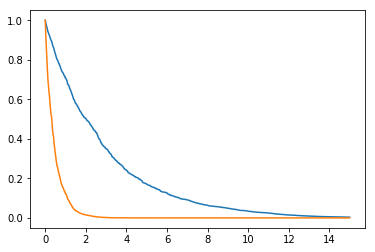

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.99796395e-01,   9.99592685e-01, ...,
           3.72875930e-03,   3.72875930e-03,   3.72875930e-03],
        [  1.00000000e+00,   9.98770770e-01,   9.97542171e-01, ...,
           2.14411286e-15,   2.14411286e-15,   2.14411286e-15]]),
 array([ 2.        ,  1.99856716,  1.99713486, ...,  0.00372876,
         0.00372876,  0.00372876]))

In [9]:
model.survivalRate(X[-2:])

### 总结

- 网络需要参数需要优化，调整（自动化调参？贝叶斯优化参数？）
- 网络性能波动很大，最终网络对比例风险的估计存在波动（每次实验结果都不一样，随机数种子的问题？）
- 网络对特征重要性的评估：不稳定，不准确，存在负重要性分数！（采用模拟数据，有时候得到的特征重要性偏差很大）
- 对生存函数的估计？

In [3]:
import tensorflow as tf

print(tf.global_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'training_step/global_step:0' shape=() dtype=int32_ref>]


In [4]:
with tf.Session() as sess:
    c = tf.get_collection('losses')
    x = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    y = tf.get_collection(tf.GraphKeys.WEIGHTS)
    print(c, x, y)

[] [<tf.Tensor 'layer1/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer2/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer_last/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'get_regularization_penalty:0' shape=() dtype=float32>] []


In [5]:
print(tf.trainable_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>]
